### Imports

In [58]:
from pykeen.pipeline import pipeline
from pykeen.models import TransE
from pykeen.datasets import Nations
from pykeen.datasets import YAGO310

from pykeen.models.predict import get_relation_prediction_df
from pykeen.models.predict import get_all_prediction_df

from pykeen.datasets.analysis import get_relation_count_df
from pykeen.datasets.analysis import get_entity_count_df
#from pykeen.datasets.analysis import get_relation_functionality_df
#from pykeen.datasets.analysis import get_entity_relation_co_occurrence_df
from pykeen.datasets.analysis import get_relation_pattern_types_df

from pykeen.triples.triples_factory import tensor_to_df
from pykeen.triples.triples_factory import CoreTriplesFactory

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

### Exploration

In [2]:
dataset = Nations()

In [3]:
print(dataset)

Nations(num_entities=14, num_relations=55, create_inverse_triples=False)


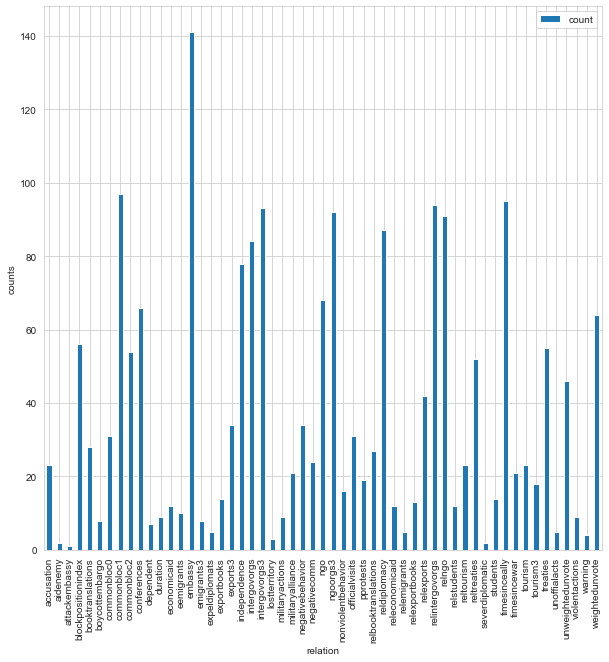

In [28]:
relation_count = get_relation_count_df(dataset)

ax = relation_count.plot.bar(x='relation_label', y='count', rot=90)
ax.set_xlabel("relation")
ax.set_ylabel("counts")

plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=10,10

    entity_id  count entity_label
0           0    260       brazil
1           1    146        burma
2           2    249        china
3           3    232         cuba
4           4    284        egypt
5           5    302        india
6           6    215    indonesia
7           7    243       israel
8           8    146       jordan
9           9    313  netherlands
10         10    287       poland
11         11    462           uk
12         12    514          usa
13         13    331         ussr


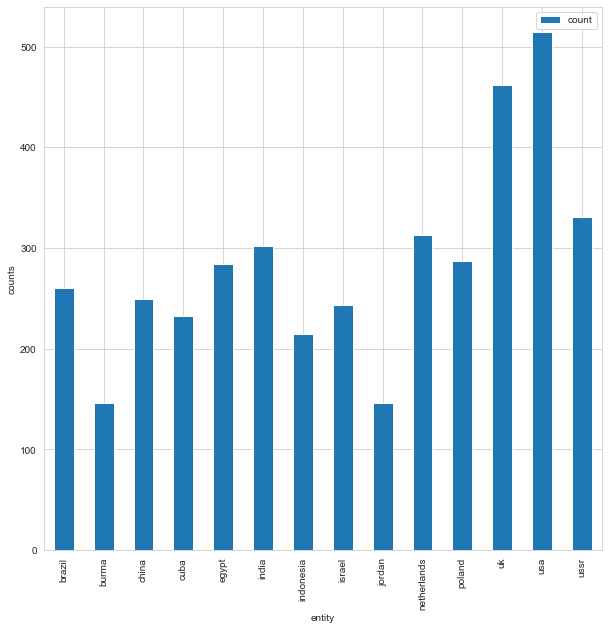

In [29]:
entity_count = get_entity_count_df(dataset)

print(entity_count)

ax = entity_count.plot.bar(x='entity_label', y='count', rot=90)
ax.set_xlabel("entity")
ax.set_ylabel("counts")

plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=10,10

In [6]:
relation_pattern = get_relation_pattern_types_df(dataset)

relation_pattern['pattern'].value_counts()


composition      57
symmetry         13
anti-symmetry    10
inversion         9
Name: pattern, dtype: int64

### Loading TransE

In [7]:
from pykeen.pipeline import pipeline
pipeline_result = pipeline(
    dataset= dataset,
    model= TransE,
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    result_tracker='mlflow',
    result_tracker_kwargs=dict(
        tracking_uri='http://localhost:5000',
        experiment_name='Training of TransE on Nations',
    ),
    device='cpu'
)
#pipeline_result.save_to_directory(r'C:\Users\tommy\OneDrive\Documenten\year 3\Bachelor AI Project\coding')

No random seed is specified. Setting to 2180012965.
E:\AnacondaPython\envs\Thesis\lib\site-packages\pykeen\nn\representation.py:372: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
Training epochs on cpu: 100%|██████████| 5/5 [00:00<00:00,  6.93epoch/s, loss=0.00585, prev_loss=0.00598]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████| 201/201 [00:00<00:00, 7.17ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


In [8]:
print(pipeline_result)

PipelineResult(random_seed=2180012965, model=TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(14, 50)
  )
  (relation_embeddings): Embedding(
    (_embeddings): Embedding(55, 50)
  )
), training=TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="E:\AnacondaPython\envs\Thesis\Lib\site-packages\pykeen\datasets\nations\train.txt"), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x000002A926E3E800>, losses=[0.0064006318249295105, 0.006262411124742211, 0.005950731098951407, 0.005976402280318677, 0.005846424917479855], metric_results=<pykeen.evaluation.rank_based_evaluator.RankBasedMetricResults object at 0x000002A92735E260>, train_seconds=0.8597798347473145, evaluate_seconds=0.042038917541503906, stopper=<pykeen.stoppers.stopper.NopStopper object at 0x000002A9273DC850>, configuration={'dataset': 'nations', 'da

In [69]:
mapped_triples = dataset.training.mapped_triples
print(mapped_triples)

tensor([[ 0,  3,  2],
        [ 0,  3,  3],
        [ 0,  3, 10],
        ...,
        [13, 54,  9],
        [13, 54, 11],
        [13, 54, 12]])


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <AxesSubplot:title={'center':'Entity/Relation Plot using PCA'}>],
       dtype=object))

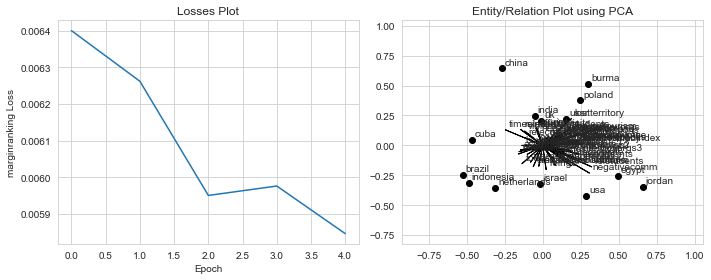

In [44]:
pipeline_result.plot()

### Loading Link Prediction Model

In [12]:
df = get_relation_prediction_df(pipeline_result.model, 'brazil', 'uk', triples_factory=pipeline_result.training)

In [13]:
print(pipeline_result.training)

TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="E:\AnacondaPython\envs\Thesis\Lib\site-packages\pykeen\datasets\nations\train.txt")


In [14]:
df.head()

,relation_id,relation_label,score,in_training
22,22,lostterritory,-7.134487,False
52,52,violentactions,-7.953715,False
3,3,blockpositionindex,-8.103345,False
26,26,negativecomm,-8.110641,False
10,10,dependent,-8.180495,False


In [15]:
print(df[['relation_label', 'score']])

         relation_label      score
22        lostterritory  -7.134487
52       violentactions  -7.953715
3    blockpositionindex  -8.103345
26         negativecomm  -8.110641
10            dependent  -8.180495
23      militaryactions  -8.195609
44             students  -8.291573
51     unweightedunvote  -8.295061
50         unoffialacts  -8.338001
4      booktranslations  -8.374750
30       officialvisits  -8.412395
6           commonbloc0  -8.442737
41           reltourism  -8.527644
45        timesinceally  -8.530023
8           commonbloc2  -8.532161
11             duration  -8.575221
2         attackembassy  -8.654040
36       relexportbooks  -8.669625
21        intergovorgs3  -8.742758
37           relexports  -8.782584
17          exportbooks  -8.861681
1              aidenemy  -8.892516
28             ngoorgs3  -8.898722
54       weightedunvote  -8.950154
46         timesincewar  -8.974232
20         intergovorgs  -9.042413
38      relintergovorgs  -9.059064
13           eemigra

In [74]:
top_df = get_all_prediction_df(pipeline_result.model, k=10780, remove_known=False,  triples_factory=pipeline_result.training)

scoring: 100%|██████████| 770/770 [00:00<00:00, 4.49kbatch/s]


In [72]:
top_df.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_training
0,7,israel,10,dependent,7,israel,-5.879909,False
1,5,india,10,dependent,5,india,-5.879909,False
2,12,usa,10,dependent,12,usa,-5.879910,False
3,1,burma,10,dependent,1,burma,-5.879910,False
4,11,uk,10,dependent,11,uk,-5.879910,False


In [73]:
top_df.iloc[::-1]

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_training
10779,1,burma,38,relintergovorgs,4,egypt,-13.543520,False
10778,7,israel,13,eemigrants,9,netherlands,-13.438961,False
10777,7,israel,13,eemigrants,1,burma,-13.005720,False
10776,10,poland,41,reltourism,0,brazil,-12.965244,False
10775,1,burma,47,tourism,4,egypt,-12.951047,False
...,...,...,...,...,...,...,...,...
4,11,uk,10,dependent,11,uk,-5.879910,False
3,1,burma,10,dependent,1,burma,-5.879910,False
2,12,usa,10,dependent,12,usa,-5.879910,False
1,5,india,10,dependent,5,india,-5.879909,False


In [27]:
print(top_df[['head_label', 'relation_label', 'tail_label', 'score', 'in_training']])

      head_label   relation_label   tail_label      score  in_training
0         israel        dependent       israel  -5.879909        False
1          india        dependent        india  -5.879909        False
2            usa        dependent          usa  -5.879910        False
3          burma        dependent        burma  -5.879910        False
4             uk        dependent           uk  -5.879910        False
...          ...              ...          ...        ...          ...
10775      burma          tourism        egypt -12.951047        False
10776     poland       reltourism       brazil -12.965244        False
10777     israel       eemigrants        burma -13.005720        False
10778     israel       eemigrants  netherlands -13.438961        False
10779      burma  relintergovorgs        egypt -13.543520        False

[10780 rows x 5 columns]


In [19]:
set(top_df['head_label']).intersection(top_df['tail_label'])

{'brazil',
 'burma',
 'china',
 'cuba',
 'egypt',
 'india',
 'indonesia',
 'israel',
 'jordan',
 'netherlands',
 'poland',
 'uk',
 'usa',
 'ussr'}

means that there are entities with reflexive relations?

In [20]:
list(set(top_df['head_label']) - set(top_df['tail_label']))

[]

### Assuming links as true or false

In [21]:
print(Nations)

<class 'pykeen.datasets.nations.Nations'>


### Model to determine difference in rankings 
#### (probably Kendal Tau)
